In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
#add parent folder to path 

sys.path.append('..')

import numpy as np
import sr_mcmc as srmc
import argparse
import config_lib as cl
import deathTimesDataSet as dtds
import ast
import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee
import readFollicles as rf
import SRclass_follicles as srf


In [2]:
config_path = "configs_follicles_menopause"
apply_thresh = True


In [3]:
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())

In [4]:
config = cl.read_configs(config_path)
nsteps = int(config.get('DEFAULT', 'nsteps'))
npeople = int(config.get('DEFAULT', 'npeople'))
t_end = int(config.get('DEFAULT', 't_end'))
nwalkers = int(config.get('DEFAULT', 'nwalkers'))
nsteps = int(config.get('DEFAULT', 'nsteps'))
num_mcmc_steps = int(config.get('DEFAULT', 'n_mcmc_steps'))
metric = config.get('DEFAULT', 'metric')
time_range = ast.literal_eval(config.get('DEFAULT', 'time_range'))
time_step_multiplier = int(config.get('DEFAULT', 'time_step_multiplier'))
data_file = config.get('DEFAULT', 'data_file')
seed_file = config.get('DEFAULT', 'seed_file')
variations = ast.literal_eval(config.get('DEFAULT', 'variations'))
prior = int(config.get('DEFAULT', 'prior'))
index = int(config.get('DEFAULT', 'index'))
submission_folder = config.get(f'SUBMISSION_{index-1}', 'submission_folder')
external_hazard = config.get('DEFAULT', 'external_hazard')
if external_hazard == "None":
    external_hazard = np.inf

#all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
# (remove everything before the current folder name)
data_file = data_file.split(f'/{current_folder}/')[-1]
seed_file = seed_file.split(f'/{current_folder}/')[-1]
submission_folder = submission_folder.split(f'/{current_folder}/')[-1]
#remove the first / from the paths




h5_folder = f"{submission_folder}/h5_files"

In [5]:
print(data_file)

meno_synthetic_data_golshiri2016.csv


In [6]:
ds = rf.folliclesFromFile(data_file)
ds.external_hazard = external_hazard
seed = rf.readSeedFollicles(seed_file)

In [7]:
print(seed)

[0.00036562 0.00329803 0.02043081]


In [8]:
samples0, lnprobs0 = srmc.loadSamplesFromDir(h5_folder, best=False, thin =5, discard=200)


In [9]:
len(samples0)

2040192

In [10]:
print(np.max(lnprobs0))

-2862.463050947243


thresh: -2884.7094780246107


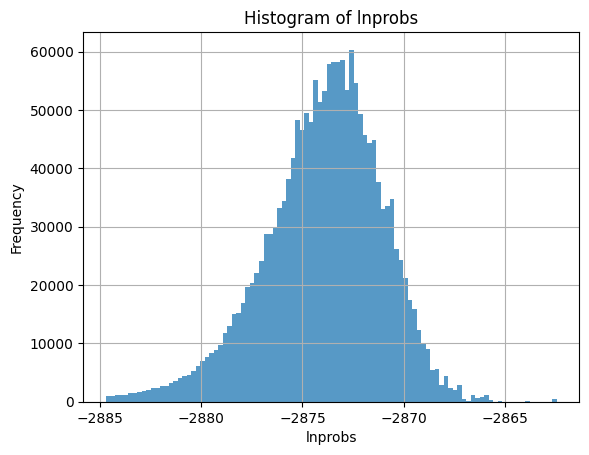

In [15]:
#plot a histogram of lnprobs2
#thresh is the threshold for lnprobs. lnprobs below thresh are not plotted
#thresh is the 95th percentile of lnprobs
thresh = np.percentile(lnprobs0, 15)
print(f"thresh: {thresh}")
# thresh = -np.inf
plt.hist(lnprobs0[lnprobs0>thresh], bins=100, alpha=0.75)
plt.xlabel('lnprobs')
plt.ylabel('Frequency')
plt.title('Histogram of lnprobs')
plt.grid(True)
plt.show()

In [16]:
if apply_thresh:
    samples = samples0[lnprobs0>thresh]
    lnprobs = lnprobs0[lnprobs0>thresh]

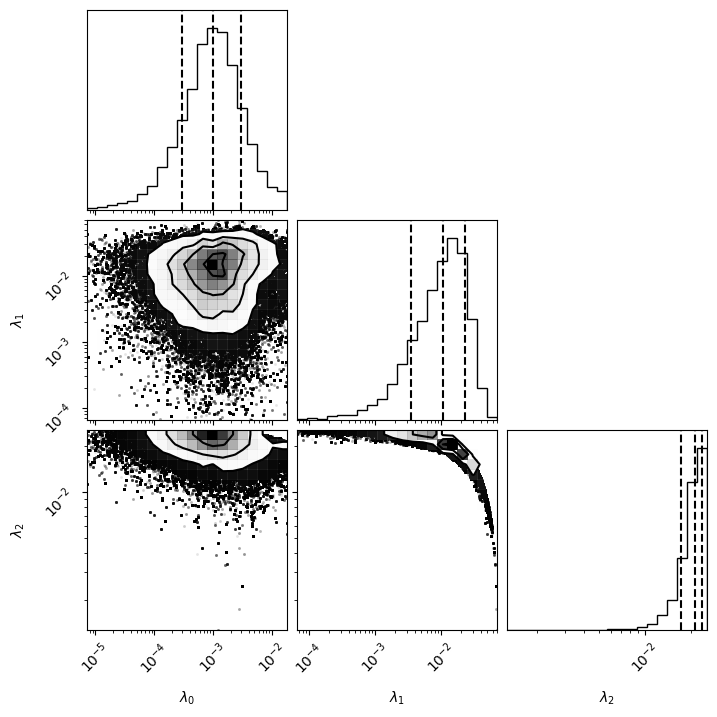

In [17]:
fig = corner.corner(samples, labels=['$\\lambda_0$','$\\lambda_1$','$\\lambda_2$'],axes_scale='log',quantiles=[0.16, 0.5, 0.84])

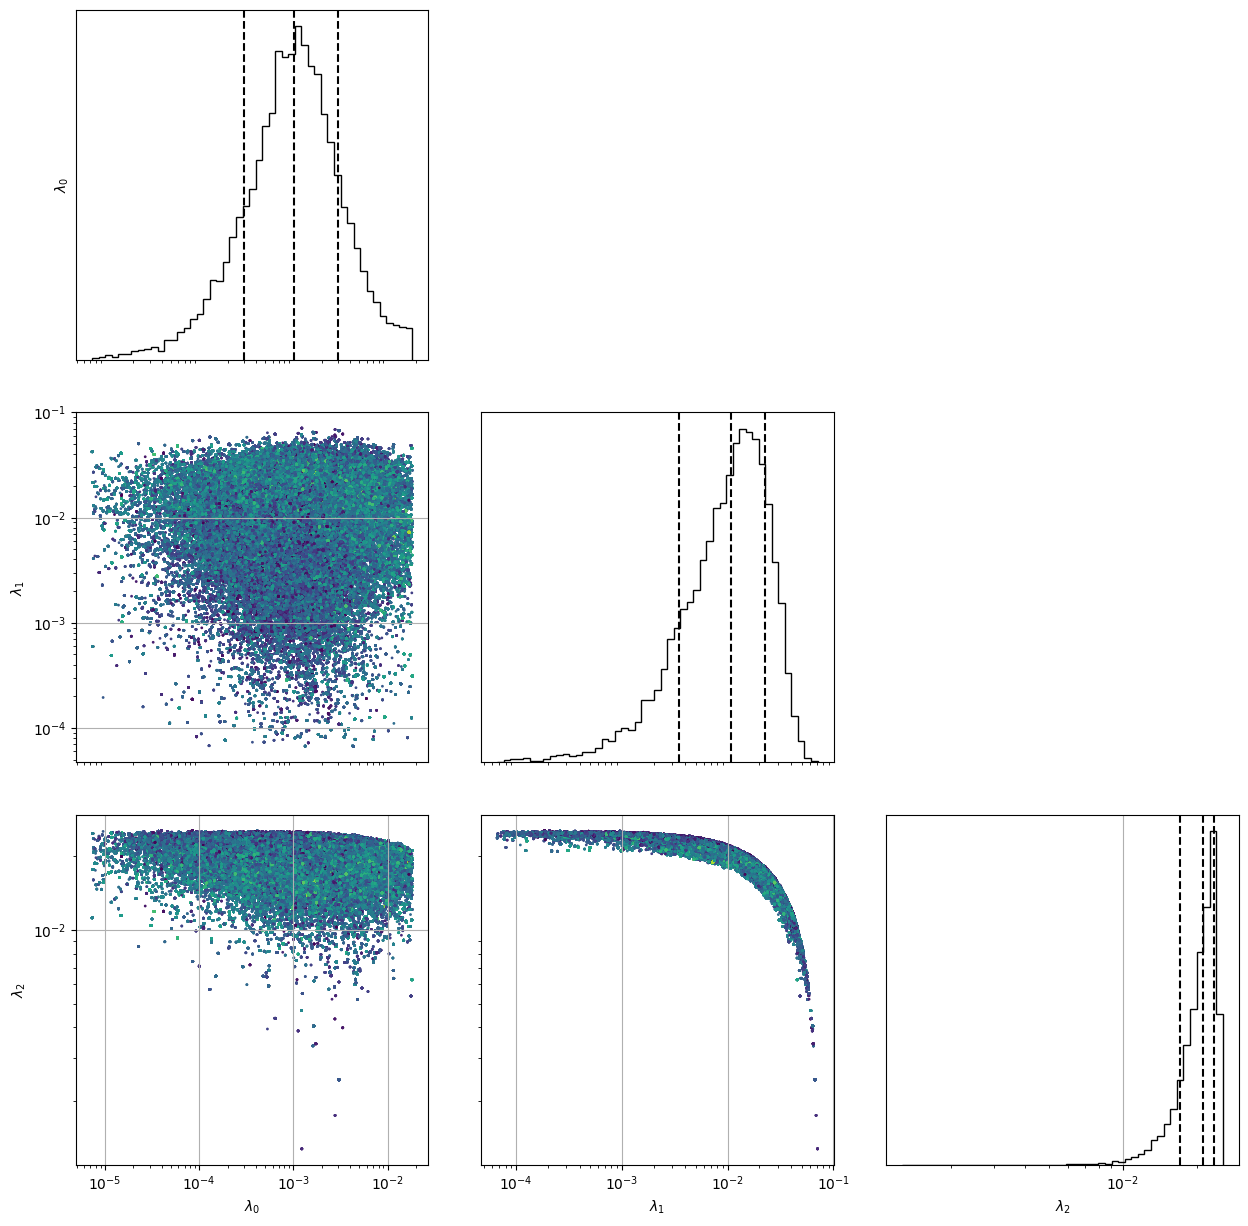

In [18]:
fig,ax=srmc.custom_corner(samples,lnprobs, labels=['$\\lambda_0$','$\\lambda_1$','$\\lambda_2$'])

In [19]:
sorted_samples = samples[np.argsort(lnprobs)]
sorted_lnprobs = lnprobs[np.argsort(lnprobs)]
theta_best = sorted_samples[-1]
params =srmc.karin_theta()

In [20]:
sim_best = srf.getSrFollicles(theta_best, params, t_end=t_end, npeople=npeople, nsteps=nsteps,time_step_multiplier=time_step_multiplier,parallel=True)

In [21]:
ds2 = rf.folliclesFromFile('df_rounded_base2.csv')


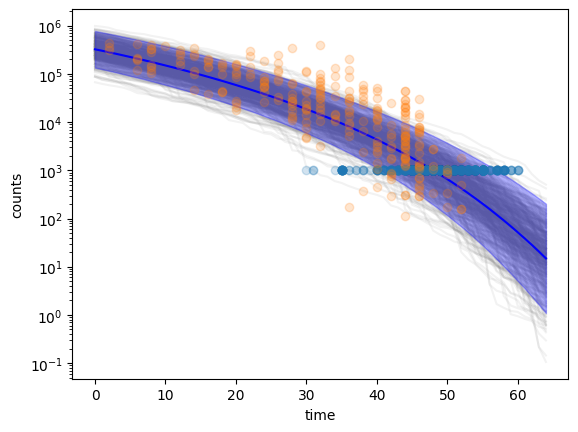

In [22]:
ax =sim_best.plotFollicles(ntrajectories=500, nstds=2, logstats=True, randomize_index=True)
ds.plotData(ax=ax,alpha=0.2)
ds2.plotData(ax=ax,alpha =0.2)
#make the markers show on top of the lines
for line in ax.get_lines():
    line.set_zorder(1)
for marker in ax.collections:
    marker.set_zorder(2)
ax.patch.set_visible(False)
ax.set_yscale('log')

In [23]:
print(theta_best)

[0.00041763 0.01977026 0.01835568]


In [24]:
print(theta_best)

[0.00041763 0.01977026 0.01835568]


Averaging log-probabilities: 100%|██████████| 2981/2981 [00:00<00:00, 379448.89it/s]


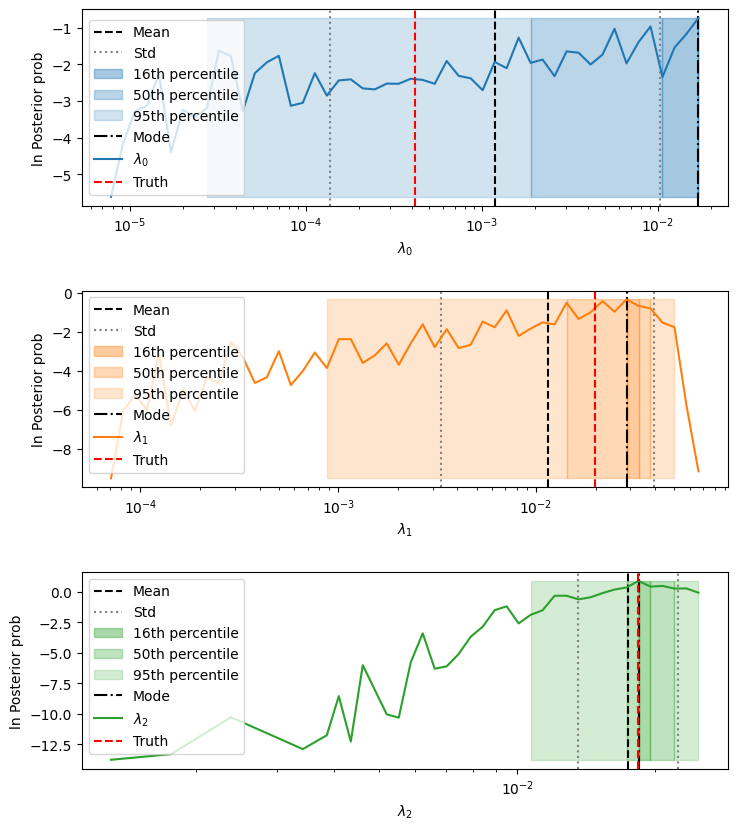

In [25]:
import samples_utils as su

post = su.Posterior(samples, lnprobs, 50, log=True)
post.plot_1d_posteriors(labels=["$\\lambda_0$","$\\lambda_1$","$\\lambda_2$"],scale='log',show_ln_prob=True, truths=theta_best,smooth_mode=False)

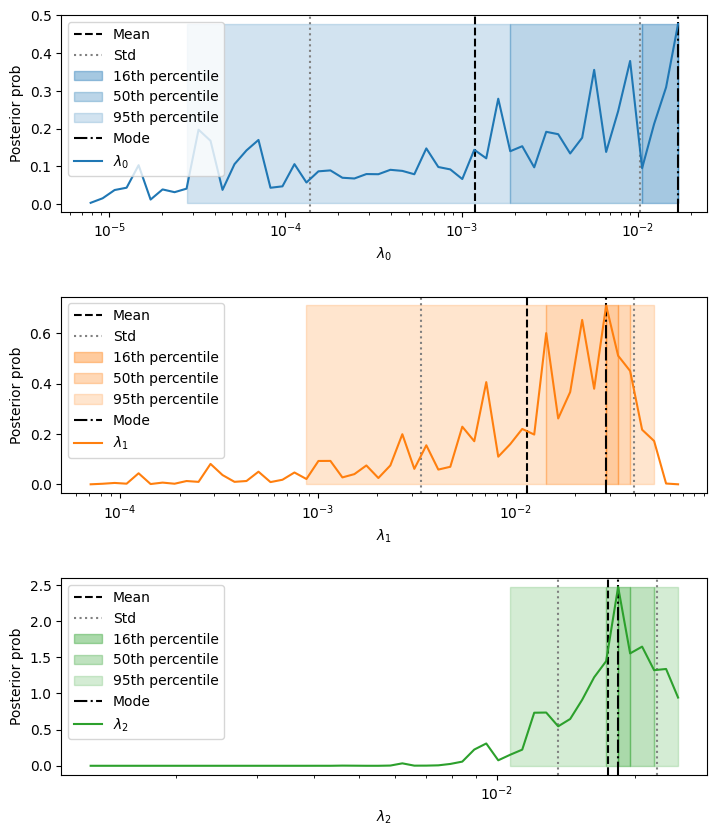

In [26]:
post.plot_1d_posteriors(labels=["$\\lambda_0$","$\\lambda_1$","$\\lambda_2$"],scale='log',show_ln_prob=False,smooth_mode=False)

Creating corner plot: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


array([[<Axes: xlabel='$\\lambda_0$', ylabel='ln Posterior prob'>,
        <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$\\lambda_0$', ylabel='$\\lambda_1$'>,
        <Axes: xlabel='$\\lambda_1$', ylabel='ln Posterior prob'>,
        <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$\\lambda_0$', ylabel='$\\lambda_2$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\lambda_1$', ylabel='$\\lambda_2$'>,
        <Axes: xlabel='$\\lambda_2$', ylabel='ln Posterior prob'>]],
      dtype=object)

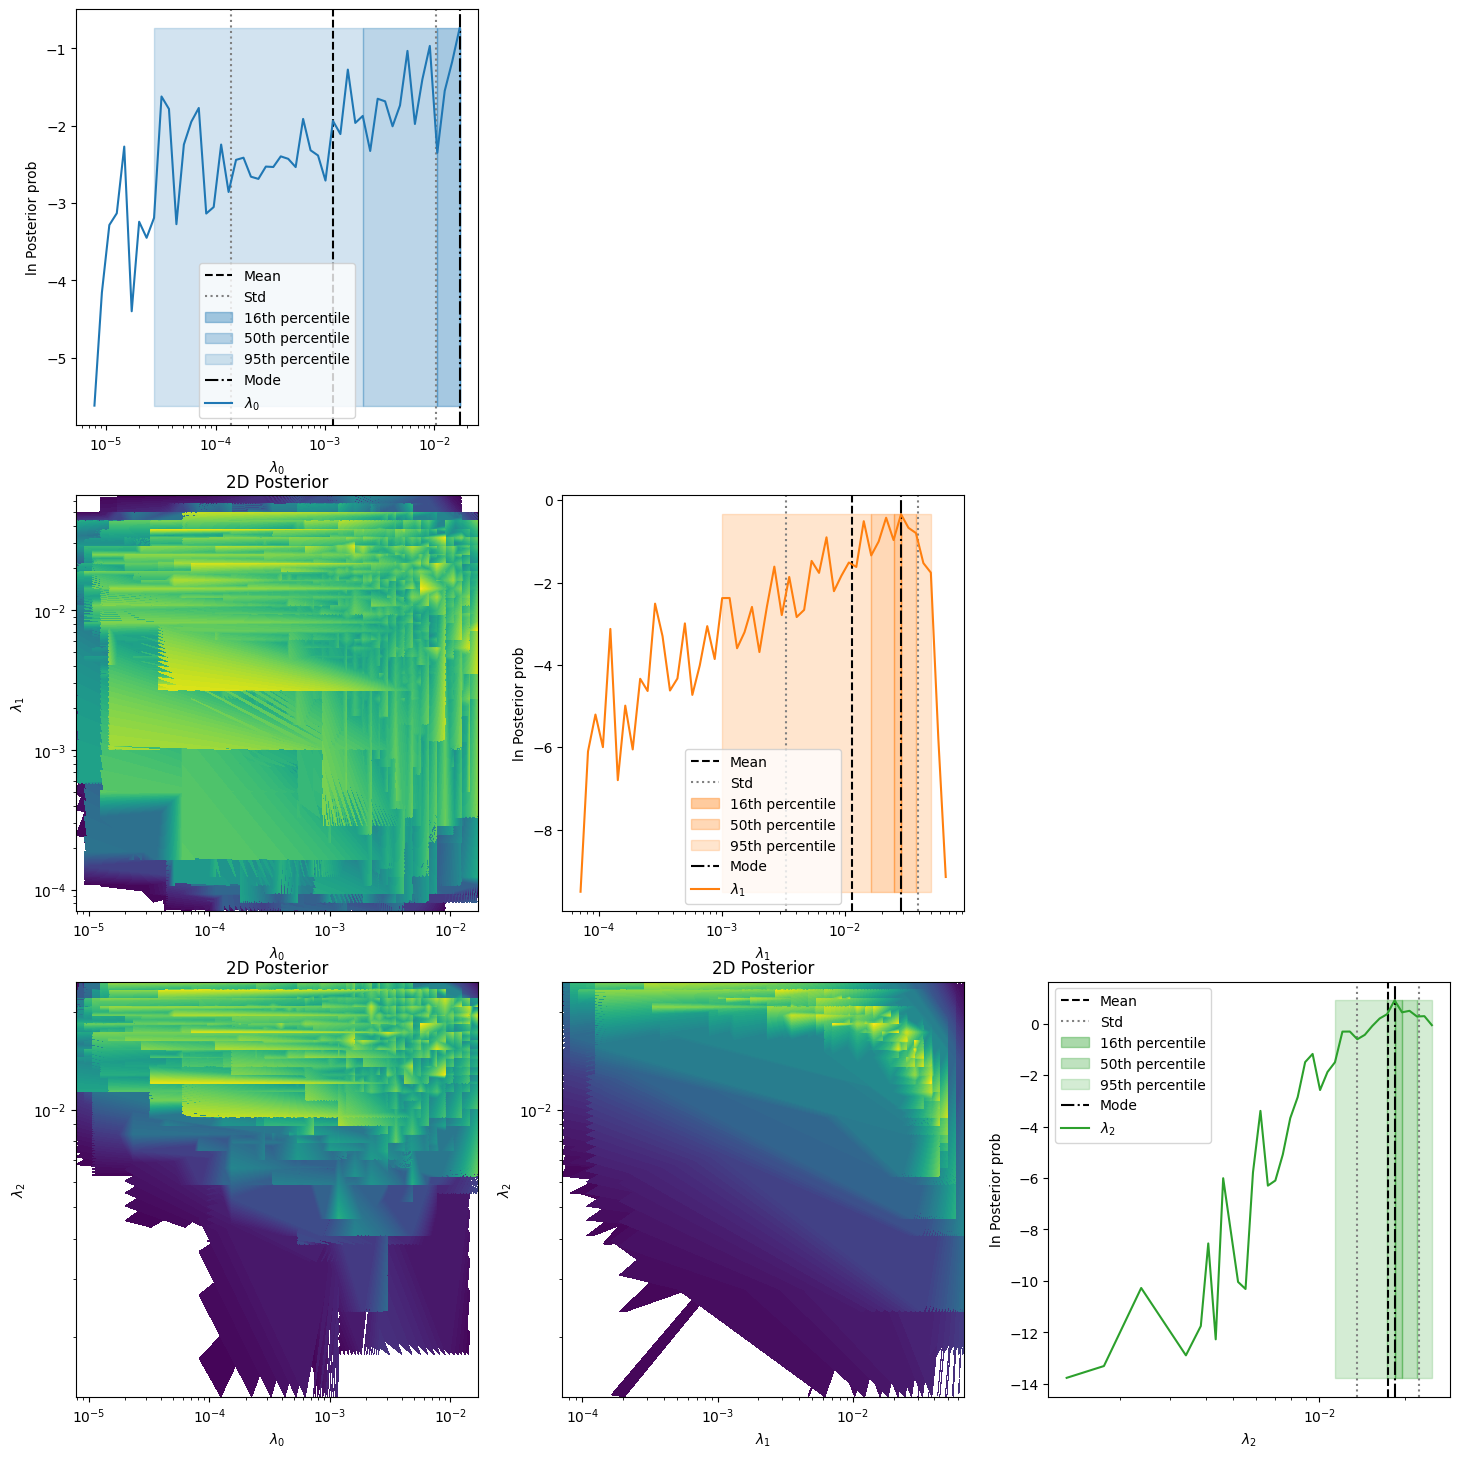

In [27]:
post.corner_plot(labels=["$\\lambda_0$","$\\lambda_1$","$\\lambda_2$"],scale='log',show_ln_prob=True, plot_type="contourf")

In [28]:
df =post.create_posterior_df(transforms=[su.identity_transform],labels=[["$\\lambda_0$","$\\lambda_1$","$\\lambda_2$"]],smooth_mode=False)

Averaging log-probabilities: 100%|██████████| 2981/2981 [00:00<00:00, 407297.55it/s]


In [29]:
df

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood
$\lambda_0$,0.00119,"[0.00912, 0.00105]",0.017,"[0.0106, 0.017]","[0.00189, 0.017]","[2.74e-05, 0.017]",0.000418
$\lambda_1$,0.0114,"[0.028, 0.00812]",0.0287,"[0.0287, 0.033]","[0.0143, 0.0379]","[0.000875, 0.0501]",0.0198
$\lambda_2$,0.0174,"[0.00495, 0.00385]",0.0184,"[0.0184, 0.0195]","[0.0173, 0.022]","[0.0107, 0.0248]",0.0184
